# Coursera IBM Data Science Professional Qualification - Week 2 (Part 3)

``` "Explore and cluster the neighborhoods in Toronto. You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data. It is up to you." ```

In [1]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import requests
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

from pandas.io.json import json_normalize
from sklearn.cluster import KMeans
from IPython.core.display import display,HTML, Image


## Load data from previous part of the assignment

In [2]:
filepath = 'week_2_part2_data.parquet'
toronto_df = pq.read_table(filepath).to_pandas()
toronto_df.head()

C:\Users\rosst\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:708: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels = getattr(columns, 'labels', None) or [
C:\Users\rosst\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:735: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  return pd.MultiIndex(levels=new_levels, labels=labels, names=columns.names)
C:\Users\rosst\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


,Postal Code,Borough,Neighbourhood,postal_code,place_name,latitude,longitude,accuracy
0,M3A,North York,Parkwoods,M3A,North York (York Heights / Victoria Village / ...,43.7545,-79.3300,1.0
1,M4A,North York,Victoria Village,M4A,North York (Sweeney Park / Wigmore Park),43.7276,-79.3148,6.0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",M5A,Downtown Toronto (Regent Park / Port of Toronto),43.6555,-79.3626,6.0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",M6A,North York (Lawrence Manor / Lawrence Heights),43.7223,-79.4504,6.0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",M7A,Queen's Park Ontario Provincial Government,43.6641,-79.3889,NaN


## Use K-means Clustering to Identify Areas with Similar Restaurants

### Define Functions to Query Foursquare:

Load credentials from file not uploaded to github:

In [3]:
s=pd.read_json('./secret/Foursquare_credentials.json')
CLIENT_ID = s.loc[0,'CLIENT_ID']
CLIENT_SECRET = s.loc[0,'CLIENT_SECRET']

Define a function to query foursquare, based on the API reference here: https://developer.foursquare.com/docs/api-reference/venues/search/#parameters

In [4]:
def foursquare_places_query(CLIENT_ID,CLIENT_SECRET, v,**kwargs):
    '''Returns the results of a foursquare query, based on the developer API, here: https://api.foursquare.com/v2/venues/search
    
    args:
    Required:
    CLIENT_ID
    CLIENT_SECRET
    v = version date in yyyymmdd format e.g. '20180605'
    
    Conditionally required (i.e. required if):
    The following are possible key word arguments & take string values (info from foursquare API reference https://developer.foursquare.com/docs/api-reference/venues/search/#parameters):
    
    ll = longitude latitude, required unless near is provided. Latitude and longitude of the user’s location specified as two numbers separated by a comma e.g. '1.0,1.0'
    near = required unless ll is provided. A string naming a place in the world. If the near string is not geocodable, returns a failed_geocode error. Otherwise, searches within the bounds of the geocode and adds a geocode object to the response.
    
    Optional:
    radius = Limit results to venues within this many meters of the specified location. Defaults to a city-wide area. Only valid for requests that use categoryId or query. 
    query = search term to be applied against venue names.
    limit = number of results to return, up to 50.
    categoryId = A comma separated list of categories to limit results to. If you specify categoryId. Specifying a radius may improve results. If specifying a top-level category, all sub-categories will also match the query.
    llAcc = Accuracy of latitude and longitude, in meters.
    alt = Altitude of the user’s location, in meters.
    altAcc = Accuracy of the user’s altitude, in meters.
    url = A third-party URL which foursquare will attempt to match against our map of venues to URLs.
    providerId = Identifier for a known third party that is part of our map of venues to URLs, used in conjunction with linkedId.
    linkedId = Identifier used by third party specified in providerId, which we will attempt to match against our map of venues to URLs.   
    '''
    base_url = 'https://api.foursquare.com/v2/venues/search?'
    query_string = '&client_id='+str(CLIENT_ID)+'&client_secret='+str(CLIENT_SECRET)+'&v='+str(v)
    #Construct the query string from the key word arguments:
    for key,value in kwargs.items():
        query_string = query_string+'&{}={}'.format(key,value)
    combined_url = base_url + query_string
    #Request data
    r =requests.get(combined_url).json()
    return r
    

Define a function to convert the foursquare data into a dataframe

In [5]:
def dataframe_of_foursquare_venues(CLIENT_ID,CLIENT_SECRET,v,**kwargs):
    '''Returns a dataframe of venues matching a foursquare query specified by the kwargs (see foursquare_places_query for detail on suitable kwargs)'''
    #Query foursquare
    foursquare_query = foursquare_places_query(CLIENT_ID,CLIENT_SECRET,v,**kwargs)
    #The results are in a json format, so convert this to a dataframe using json_normalize
    df = json_normalize(foursquare_query['response']['venues'])
    df.set_index(['id'])
    #Split out the venue categories
    def df_of_venue_categories(df):
        categories_df = pd.DataFrame()
        for index, row in df.iterrows():
            #isolate categories data for this venue
            temp_df = json_normalize(row['categories'])
            temp_df['id'] = row['id']
            temp_df.set_index('id')
            #Add the unfolded data to a consolidated dataframe
            if len(categories_df) == 0:
                categories_df = temp_df
            else:
                categories_df = categories_df.merge(temp_df,how='outer').fillna("")
        return categories_df
    df = df.join(df_of_venue_categories(df),how='left',rsuffix='.category')
    df.drop(columns=['categories'],inplace=True)
    return df
    

### For each neighbourhood in the Toronto Dataframe, use the Foursquare API to find out what the top restaurants are

In [6]:
FOURSQUARE_VERSION = '20180605'

In [7]:
for index, row in toronto_df.iterrows():
    longlatstr = str(row['latitude'])+','+str(row['longitude'])
    try:
        #load the restaurant data for this neighbourhood
        restaurant_df = dataframe_of_foursquare_venues(CLIENT_ID,CLIENT_SECRET,v=FOURSQUARE_VERSION,ll=longlatstr,query='restaurant')
        #count the top restaurants by shortName e.g. 'Indian'
        count_of_top_restaurants  = restaurant_df['shortName'].value_counts()
        #output this information into toronto_df & report it to the user
        for key, value in count_of_top_restaurants.to_dict().items():
            #if a suitable column exists then add the value, otherwise add a new column & populate that
            if key in toronto_df.columns:
                toronto_df.loc[index,key]= value
            else:
                #Initialise the new column with zeros
                toronto_df[key] = 0
                toronto_df.loc[index,key] = value
        print('Top {} Restaurants in {} are: \n {}'.format(sum(count_of_top_restaurants),row['Neighbourhood'],count_of_top_restaurants))
    except:
        print('Could not download venues for {} '.format(row['Neighbourhood']))

Top 30 Restaurants in Parkwoods are: 
 Chinese           9
Japanese          4
Caribbean         4
Cantonese         2
Vietnamese        2
Indian            2
Restaurant        1
Asian             1
Korean            1
Xinjiang          1
Italian           1
Szechuan          1
Middle Eastern    1
Name: shortName, dtype: int64
Top 30 Restaurants in Victoria Village are: 
 Caribbean        5
Chinese          5
Japanese         4
Restaurant       3
Indian           3
Asian            1
Korean           1
Breakfast        1
Filipino         1
Mediterranean    1
Xinjiang         1
Italian          1
Vietnamese       1
Thai             1
Ethiopian        1
Name: shortName, dtype: int64
Top 30 Restaurants in Regent Park, Harbourfront are: 
 Chinese        5
Restaurant     5
American       4
Breakfast      2
Bar            2
Wine Bar       1
Event Space    1
Italian        1
Korean         1
African        1
Vietnamese     1
Szechuan       1
Dim Sum        1
Indian         1
Thai           1


In [8]:
#drop irrelevant columns, na values and restaurants with category 'restaurant' as this is not a useful description for the purpose of this assignment
try:
    toronto_df.drop(columns=['postal_code', 'place_name', 'accuracy'],inplace=True)
except:
    pass
try:
     toronto_df.drop(columns=['Restaurant'],inplace=True)
except:
    pass

toronto_df.dropna(inplace=True)
toronto_df.head()

,Postal Code,Borough,Neighbourhood,latitude,longitude,Chinese,Japanese,Caribbean,Cantonese,Vietnamese,...,Halal,Fried Chicken,Afghan,Warehouse Store,Dumplings,Other Event,Music Venue,Furniture / Home,Dutch,Polish
0,M3A,North York,Parkwoods,43.7545,-79.3300,9,4,4,2,2,...,0,0,0,0,0,0,0,0,0,0
1,M4A,North York,Victoria Village,43.7276,-79.3148,5,4,5,0,1,...,0,0,0,0,0,0,0,0,0,0
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626,5,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504,5,1,1,0,2,...,0,0,0,0,0,0,0,0,0,0
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889,5,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
#Incase rerunning part of the code, remove cluster labels
try:
    toronto_df.drop(columns=['Cluster Labels'],inplace=True)
    print('Old Cluster Labels Removed, ready for rerun')
except:
    pass

## Apply Clustering Algorithm to identify similar areas for restaurant options/prefererences

### Apply k-means clusteringto identify similar neighbourhoods & show these on a map

In [10]:
#Before applying kmeans clustering to toronto_df, remove the string columns which do not relate to venue types
toronto_df_clean = toronto_df.drop(columns=['Postal Code','Borough','Neighbourhood','latitude','longitude'])
toronto_df_clean.head()

,Chinese,Japanese,Caribbean,Cantonese,Vietnamese,Indian,Asian,Korean,Xinjiang,Italian,...,Halal,Fried Chicken,Afghan,Warehouse Store,Dumplings,Other Event,Music Venue,Furniture / Home,Dutch,Polish
0,9,4,4,2,2,2,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,5,4,5,0,1,3,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,5,0,0,0,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
3,5,1,1,0,2,1,0,5,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,1,0,0,1,0,4,0,1,...,0,0,0,0,0,0,0,0,0,0


In [11]:
#set number of clusters
kclusters = 7


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_df_clean)

# check cluster labels generated for each row in the dataframe
print('Kmeans labels are {}'.format(kmeans.labels_))

Kmeans labels are [5 4 2 6 2 1 3 5 4 2 1 0 3 4 4 2 1 0 3 4 2 1 3 4 2 1 3 3 5 4 2 1 3 5 5 0 2
 1 3 5 6 4 2 1 4 5 6 4 2 1 5 5 6 6 2 6 1 6 4 5 5 6 1 1 6 3 5 4 1 1 6 5 3 1
 1 1 6 3 6 1 1 3 1 2 3 1 2 2 0 3 6 2 0 0 3 2 2 1 2 3 1 6]


In [12]:
toronto_df.insert(0, 'Cluster Labels', kmeans.labels_)
toronto_df.head()

,Cluster Labels,Postal Code,Borough,Neighbourhood,latitude,longitude,Chinese,Japanese,Caribbean,Cantonese,...,Halal,Fried Chicken,Afghan,Warehouse Store,Dumplings,Other Event,Music Venue,Furniture / Home,Dutch,Polish
0,5,M3A,North York,Parkwoods,43.7545,-79.3300,9,4,4,2,...,0,0,0,0,0,0,0,0,0,0
1,4,M4A,North York,Victoria Village,43.7276,-79.3148,5,4,5,0,...,0,0,0,0,0,0,0,0,0,0
2,2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.6555,-79.3626,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,6,M6A,North York,"Lawrence Manor, Lawrence Heights",43.7223,-79.4504,5,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.6641,-79.3889,5,0,1,0,...,0,0,0,0,0,0,0,0,0,0


### Map the clusters

In [13]:
# create map
map_clusters = folium.Map(location=[toronto_df['latitude'].mean(), toronto_df['longitude'].mean()], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
#Add each cluster to a list, its index will determine the color displayed
clusters = []

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_df['latitude'], toronto_df['longitude'], toronto_df['Neighbourhood'], toronto_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    #Work out the index to use for coloring
    if cluster not in clusters:
        clusters.append(cluster)
    cluster_index = clusters.index(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        #color=rainbow[cluster_index],
        color=colors.rgb2hex(colors_array[cluster_index]),
        fill=True,
        fill_color=rainbow[cluster_index],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

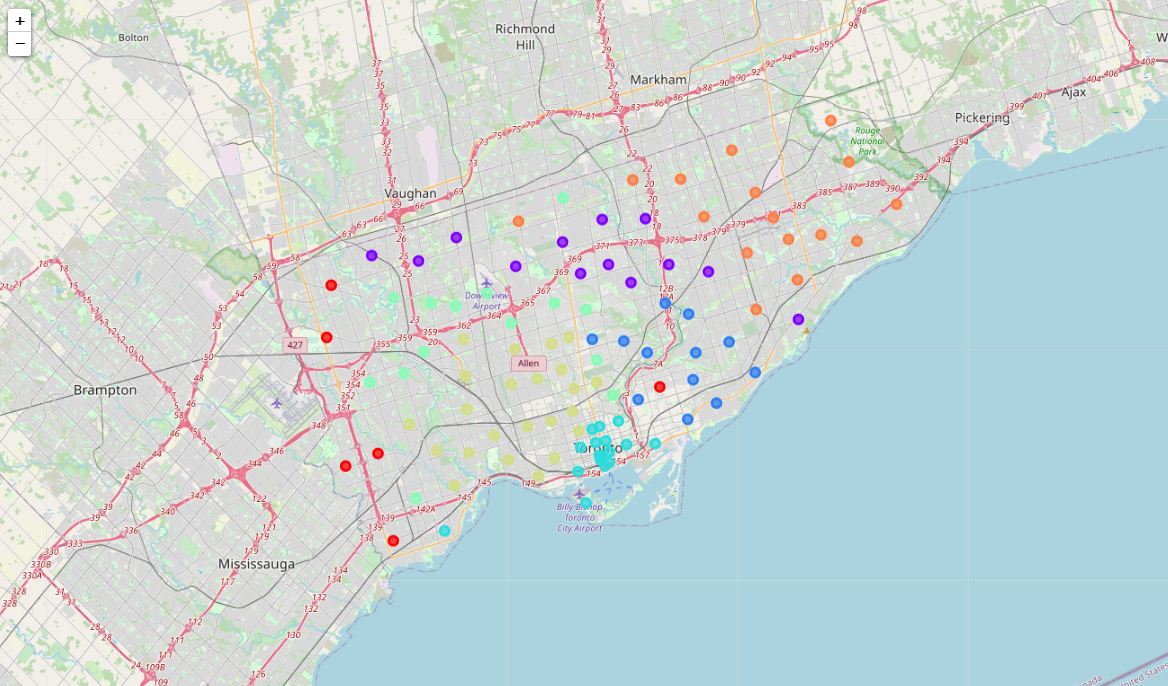

In [14]:
#Open screenshot of created folium map as github doesn't display the map but it is created by the code
Image('folium_toronto_restaurant_clusters.png')

## Look at what makes up the clusters:

In [15]:
for cluster_num in range(kclusters):
    #Restrict to just the datadrame containing the current cluster label:
    cluster_df = toronto_df[toronto_df['Cluster Labels']==cluster_num]
    #remove long and lat as these aren't needed for this analysis
    cluster_df.drop(columns=['longitude','latitude','Cluster Labels'],inplace=True)
    #work out which are the most common entries by taking an average across all items in the cluster
    frequency_of_category = cluster_df.mean().sort_values(ascending=False)
    #Add a title
    display(HTML("<h3>Restaurants in Cluster sorted from most to least popular {} </h3>".format(cluster_num)))
    #Show the list in order of most to least frequent
    display(frequency_of_category.index)


C:\Users\rosst\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


Index(['Chinese', 'American', 'Ethiopian', 'Caribbean', 'Vietnamese',
       'Middle Eastern', 'Korean', 'Xinjiang', 'Iraqi Restaurant', 'Italian',
       'Asian', 'Indian', 'Latin American', 'Thai', 'Turkish', 'Breakfast',
       'Diner', 'Nightclub', 'New American', 'Greek', 'Pizza', 'African',
       'Cantonese', 'Japanese', 'Dim Sum', 'Noodles', 'Shop', 'Steakhouse',
       'Lounge', 'Scandinavian', 'Mexican', 'Hong Kong', 'German',
       'Vegetarian / Vegan', 'Hakka', 'Cha Chaan Teng', 'Indian Chinese',
       'Filipino', 'Szechuan', 'Mediterranean', 'Bar', 'Wine Bar',
       'Event Space', 'Sushi', 'Food & Drink', 'Polish', 'Dive Bar',
       'Moroccan', 'Seafood', 'Hunan', 'Peruvian', 'Deli / Bodega', 'French',
       'Nightlife', 'Juice Bar', 'Halal', 'Karaoke', 'Fried Chicken', 'Afghan',
       'Warehouse Store', 'Dumplings', 'Other Event', 'Music Venue',
       'Furniture / Home', 'Caucasian', 'Tibetan', 'Burgers', 'Mongolian',
       'Grocery Store', 'Dutch', 'Vineyard', 'H

Index(['Korean', 'Chinese', 'New American', 'Ethiopian', 'Vietnamese',
       'Dim Sum', 'Nightclub', 'Noodles', 'Diner', 'Japanese', 'Thai',
       'Breakfast', 'Caribbean', 'Italian', 'Bar', 'American', 'Event Space',
       'Indian', 'Latin American', 'Middle Eastern', 'Turkish', 'Portuguese',
       'Asian', 'Szechuan', 'Café', 'Xinjiang', 'Sushi', 'Deli / Bodega',
       'Steakhouse', 'Eastern European', 'French', 'Mexican',
       'Iraqi Restaurant', 'Cantonese', 'Filipino', 'Grocery Store', 'Pizza',
       'Mediterranean', 'Polish', 'Argentinian', 'Nightlife', 'Tibetan',
       'Karaoke', 'Sandwiches', 'Pub', 'Mac & Cheese', 'Juice Bar', 'Spanish',
       'Afghan', 'Seafood', 'Lebanese', 'Furniture / Home', 'Music Venue',
       'Caucasian', 'Other Event', 'Hunan', 'Fried Chicken', 'Dumplings',
       'Peruvian', 'Warehouse Store', 'Persian', 'Moroccan', 'Halal',
       'Wine Bar', 'Hungarian', 'African', 'Vineyard', 'Greek', 'Dutch',
       'Burgers', 'Dive Bar', 'German', 'Foo

Index(['Chinese', 'American', 'Bar', 'Breakfast', 'Dim Sum', 'Indian',
       'Caribbean', 'Korean', 'Noodles', 'Thai', 'New American', 'Szechuan',
       'Wine Bar', 'Vietnamese', 'Nightclub', 'Event Space', 'Diner',
       'Italian', 'Ethiopian', 'Asian', 'Japanese', 'Filipino', 'Sushi',
       'Molecular Gastronomy', 'Iraqi Restaurant', 'Mongolian', 'Pub',
       'Xinjiang', 'Greek', 'Café', 'Dutch', 'African', 'Spanish',
       'Cha Chaan Teng', 'Indian Chinese', 'Hakka', 'Vegetarian / Vegan',
       'Latin American', 'Hong Kong', 'Mediterranean', 'Pizza', 'Turkish',
       'German', 'Middle Eastern', 'Cantonese', 'Food & Drink', 'Polish',
       'Dive Bar', 'Moroccan', 'Seafood', 'Hunan', 'Peruvian', 'Deli / Bodega',
       'French', 'Nightlife', 'Juice Bar', 'Halal', 'Burgers', 'Fried Chicken',
       'Afghan', 'Warehouse Store', 'Dumplings', 'Other Event', 'Music Venue',
       'Furniture / Home', 'Caucasian', 'Karaoke', 'Tibetan', 'Lebanese',
       'Grocery Store', 'Vineyard',

Index(['Chinese', 'Korean', 'Japanese', 'Indian', 'Caribbean',
       'Vegetarian / Vegan', 'Hong Kong', 'Breakfast', 'Asian', 'Hakka',
       'Xinjiang', 'Cantonese', 'Cha Chaan Teng', 'German', 'Vietnamese',
       'Dumplings', 'Warehouse Store', 'Indian Chinese', 'American', 'Italian',
       'Filipino', 'Middle Eastern', 'Szechuan', 'Dim Sum', 'Other Event',
       'Sushi', 'Latin American', 'Pizza', 'Turkish', 'Pub', 'Bar',
       'Food Court', 'Eastern European', 'Furniture / Home', 'French', 'Thai',
       'Steakhouse', 'Food & Drink', 'Wine Bar', 'Nightclub',
       'Iraqi Restaurant', 'Diner', 'Ethiopian', 'Event Space',
       'Mediterranean', 'African', 'Noodles', 'New American', 'Polish',
       'Dive Bar', 'Burgers', 'Lebanese', 'Tibetan', 'Karaoke', 'Caucasian',
       'Seafood', 'Hunan', 'Peruvian', 'Deli / Bodega', 'Nightlife',
       'Juice Bar', 'Moroccan', 'Halal', 'Fried Chicken', 'Afghan',
       'Music Venue', 'Persian', 'Lounge', 'Café', 'Molecular Gastronomy',
 

Index(['Caribbean', 'Chinese', 'Japanese', 'Indian', 'Italian', 'Thai',
       'Ethiopian', 'Korean', 'Vietnamese', 'Asian', 'American', 'Filipino',
       'Breakfast', 'Greek', 'New American', 'Event Space', 'Hungarian',
       'Diner', 'Mediterranean', 'Noodles', 'Dive Bar', 'Burgers', 'Xinjiang',
       'Nightclub', 'Sushi', 'German', 'African', 'Bar', 'Dim Sum', 'Vineyard',
       'Turkish', 'Szechuan', 'Middle Eastern', 'Persian', 'Lebanese', 'Shop',
       'Vegetarian / Vegan', 'Hakka', 'Cantonese', 'Hong Kong', 'Wine Bar',
       'Cha Chaan Teng', 'Indian Chinese', 'Iraqi Restaurant',
       'Latin American', 'Food & Drink', 'Pizza', 'Polish', 'Grocery Store',
       'Caucasian', 'Hunan', 'Peruvian', 'Deli / Bodega', 'French',
       'Nightlife', 'Juice Bar', 'Moroccan', 'Halal', 'Fried Chicken',
       'Afghan', 'Warehouse Store', 'Dumplings', 'Other Event', 'Music Venue',
       'Furniture / Home', 'Seafood', 'Karaoke', 'Dutch', 'Tibetan', 'Spanish',
       'Molecular Gastrono

Index(['Chinese', 'Japanese', 'Caribbean', 'Korean', 'Middle Eastern',
       'Vietnamese', 'Indian', 'Hong Kong', 'Cantonese', 'Szechuan', 'Pizza',
       'Xinjiang', 'Steakhouse', 'Asian', 'Italian', 'Latin American',
       'Breakfast', 'Turkish', 'Diner', 'American', 'Ethiopian', 'Seafood',
       'Caucasian', 'Wings', 'German', 'Sushi', 'Bar', 'Vegetarian / Vegan',
       'Eastern European', 'Thai', 'Filipino', 'Afghan', 'Fried Chicken',
       'Halal', 'Moroccan', 'Peruvian', 'Hunan', 'Cha Chaan Teng', 'Hakka',
       'Café', 'Mediterranean', 'Noodles', 'Dim Sum', 'New American',
       'Iraqi Restaurant', 'African', 'Event Space', 'Wine Bar',
       'Indian Chinese', 'Nightclub', 'Polish', 'Food & Drink', 'French',
       'Lounge', 'Persian', 'Lebanese', 'Tibetan', 'Karaoke', 'Deli / Bodega',
       'Nightlife', 'Dive Bar', 'Juice Bar', 'Warehouse Store', 'Dumplings',
       'Other Event', 'Music Venue', 'Furniture / Home', 'Portuguese', 'Shop',
       'Food Court', 'Sandwiches'

Index(['Chinese', 'Korean', 'Ethiopian', 'Vietnamese', 'Caribbean', 'Japanese',
       'Nightclub', 'Middle Eastern', 'Thai', 'American', 'Latin American',
       'Italian', 'Turkish', 'Indian', 'Pizza', 'New American', 'Hong Kong',
       'Steakhouse', 'Breakfast', 'Xinjiang', 'Event Space', 'Noodles',
       'Szechuan', 'Diner', 'African', 'Dim Sum', 'Asian', 'Iraqi Restaurant',
       'Filipino', 'Bar', 'Sushi', 'Mediterranean', 'Seafood', 'French',
       'Music Venue', 'Wine Bar', 'Dive Bar', 'Cantonese', 'Indian Chinese',
       'Cha Chaan Teng', 'Hakka', 'Vegetarian / Vegan', 'Food & Drink',
       'German', 'Polish', 'Burgers', 'Grocery Store', 'Lebanese', 'Tibetan',
       'Karaoke', 'Caucasian', 'Hunan', 'Peruvian', 'Deli / Bodega',
       'Nightlife', 'Juice Bar', 'Moroccan', 'Halal', 'Fried Chicken',
       'Afghan', 'Warehouse Store', 'Dumplings', 'Other Event',
       'Furniture / Home', 'Persian', 'Lounge', 'Café', 'Mexican', 'Dutch',
       'Greek', 'Vineyard', 'Hungari